In [1]:
import netCDF4 as nc
import datetime as dt
import pandas as pd
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools, places
import xarray as xr
from salishsea_tools import evaltools as et

%matplotlib inline

Determine model grid points using lat/log

In [2]:
jjii = xr.open_dataset('/data/sallen/MEOPAR/grid/grid_from_lat_lon_mask999.nc')

In [3]:
#Find model grid location for Saanich Inlet
lat, lon = 48.59, -123.51 #Saanich Sampling Station
method = 'nearest'
jj = jjii.jj.sel(lats=lat, lons=lon, method=method).item()
ii = jjii.ii.sel(lats=lat, lons=lon, method=method).item()
print (ii, jj)

198 343


In [4]:
jjii.close()

In [5]:
jS3,iS3=places.PLACES['S3']['NEMO grid ji']

In [6]:
places.PLACES['Juan de Fuca Strait']

{'lon lat': (-124.7, 48.47)}

In [7]:
jJF,iJF=[290,130]

In [8]:
places.PLACES['Puget Sound']

{'lon lat': (-122.67, 48)}

In [9]:
jPS,iPS=[107,254]

In [10]:
jBS, iBS=places.PLACES['Baynes Sound']['NEMO grid ji']

In [11]:
jGI,iGI=[390,240]

In [12]:
jNSoG,iNSoG=[638,197]

In [13]:
jSI,iSI=[343,198]

In [14]:
df=pd.read_excel('/ocean/ksuchy/MOAD/observe/SaanichGrowthRates.xlsx',engine='openpyxl')

In [15]:
df

,dtUTC,Lat,Lon,Z_lower,Z_upper,P/B,Production (mg C m-3 d-1),Total Zoop Biomass,Crustacean Biomass,Non Crustacean Biomass,Copepod Biomass
0,2010-03-11,48.59,-123.51,100,0,0.07,1.2440,8.290669,3.243590,5.047079,0.520046
1,2010-03-18,48.59,-123.51,100,0,0.03,0.2210,4.060603,2.512094,1.548508,0.264141
2,2010-03-25,48.59,-123.51,100,0,0.19,4.2510,36.644737,30.733623,5.911114,23.101529
3,2010-04-01,48.59,-123.51,100,0,0.12,1.2260,46.617782,40.007711,6.610072,19.809854
4,2010-04-08,48.59,-123.51,100,0,0.09,1.3880,34.579127,25.701994,8.877132,12.247770
5,2010-04-22,48.59,-123.51,100,0,0.17,9.9750,262.540128,131.746410,130.793718,82.864384
6,2010-04-30,48.59,-123.51,100,0,0.33,15.6050,51.105538,44.424950,6.680588,23.486172
7,2010-05-10,48.59,-123.51,100,0,0.01,0.0500,95.222814,77.358661,17.864153,47.502435
8,2010-05-17,48.59,-123.51,100,0,0.04,0.0500,3588.541938,3365.892137,222.649801,369.704100
9,2010-06-02,48.59,-123.51,100,0,0.42,11.7550,1165.543557,930.559191,234.984366,121.311437


In [16]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    dept=np.copy(fm.variables['gdept_1d'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

### Saanich Sampling Location & S3 for Comparison

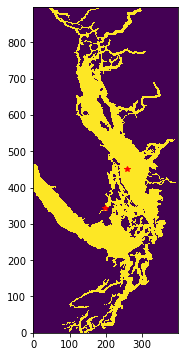

In [18]:
fig,ax=plt.subplots(1,1,figsize=(4,6))
ax.pcolormesh(tmask[0,0,:,:])
#ax.plot(130,290,'r*')
ax.plot(iS3,jS3,'r*')
#ax.plot(254,107,'r*')
#ax.plot(iBS,jBS,'r*')
#ax.plot(iGI,jGI,'r*')
#ax.plot(iNSoG,jNSoG,'r*')
ax.plot(iSI,jSI,'r*')
ax.set_aspect(1)

In [19]:
jpk100=0
for i in range(0,40): #stays same b/c grid cells or write len(dept[0]) instead of 40
    if dept[0][i]<=100:#change this to get diff depths in water column
        jpk100=i
print(jpk100)
jpk100=jpk100+1
print(jpk100)

26
27


In [20]:
koff=jpk100 # first index of depth > 100

In [21]:
t0=dt.datetime(2010,1,1) # 1st start date of run
#te=dt.datetime(2011,12,1)# last start date of runfnum=18
stm=np.shape(tmask)
#nlen=36*2
nlen=730
dlist=[t0+dt.timedelta(days=ii) for ii in range(0,nlen)]

In [22]:
#sdir0='/results/SalishSea/nowcast-green/'
#sdir1='/results/SalishSea/hindcast/'
#sdir3='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_HCMZ/'
#sdir1='/results2/SalishSea/nowcast-green.201905/'
sdir1='/results2/SalishSea/nowcast-green.201905/'

In [23]:
tmaskC=np.copy(tmask)
tmaskC[:,koff:,:,:]=0
#tmaskC[:,:,370:490,:12]=0
#tmaskC[:,:,887:,30:70]=0

In [24]:
#f=nc.Dataset('/data/sallen/results/MEOPAR/averages/SalishSea_apr_climate_2007_2019_dia2_T.nc')

In [25]:
#print(f.variables.keys())

In [26]:
tlist=dlist
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_dia2_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
meanMESZD100=np.zeros((len(tlist),))
meanMESZD100S3=np.zeros((len(tlist),))
meanMESZD100SI=np.zeros((len(tlist),))

ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t'][:2,:,:,:]
    Vol=A*e3t_0 #m3
    meanMESZD100[ind]=np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['GRMESZDIAT'][0,:,:,:])/\
            np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:])#mmol/m3 s-1
    meanMESZD100S3[ind]=np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3]*f.variables['GRMESZDIAT'][0,:,jS3,iS3])/\
            np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3 s-1
    meanMESZD100SI[ind]=np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI]*f.variables['GRMESZDIAT'][0,:,jSI,iSI])/\
            np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI])#mmol/m3 s-1
    
    
   
    f.close()
    fP.close()

/results2/SalishSea/nowcast-green.201905/01jan10/SalishSea_1d_20100101_20100101_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16jan10/SalishSea_1d_20100116_20100116_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31jan10/SalishSea_1d_20100131_20100131_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/15feb10/SalishSea_1d_20100215_20100215_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/02mar10/SalishSea_1d_20100302_20100302_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/17mar10/SalishSea_1d_20100317_20100317_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01apr10/SalishSea_1d_20100401_20100401_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16apr10/SalishSea_1d_20100416_20100416_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01may10/SalishSea_1d_20100501_20100501_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16may10/SalishSea_1d_20100516_20100516_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31may10/SalishSea_1d_20100531_20100531_dia2_T.nc
/results2/

In [27]:
tlist=dlist
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_dia2_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
meanMESZF100=np.zeros((len(tlist),))
meanMESZF100S3=np.zeros((len(tlist),))
meanMESZF100SI=np.zeros((len(tlist),))



ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t'][:2,:,:,:]
    Vol=A*e3t_0
  
    meanMESZF100[ind]=np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['GRMESZPHY'][0,:,:,:])/\
            np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:])#mmol/m3 s-1
    meanMESZF100S3[ind]=np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3]*f.variables['GRMESZPHY'][0,:,jS3,iS3])/\
            np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3 s-1
    meanMESZF100SI[ind]=np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI]*f.variables['GRMESZPHY'][0,:,jSI,iSI])/\
            np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI])#mmol/m3 s-1
    
    
    f.close()
    fP.close()

/results2/SalishSea/nowcast-green.201905/01jan10/SalishSea_1d_20100101_20100101_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16jan10/SalishSea_1d_20100116_20100116_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31jan10/SalishSea_1d_20100131_20100131_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/15feb10/SalishSea_1d_20100215_20100215_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/02mar10/SalishSea_1d_20100302_20100302_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/17mar10/SalishSea_1d_20100317_20100317_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01apr10/SalishSea_1d_20100401_20100401_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16apr10/SalishSea_1d_20100416_20100416_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01may10/SalishSea_1d_20100501_20100501_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16may10/SalishSea_1d_20100516_20100516_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31may10/SalishSea_1d_20100531_20100531_dia2_T.nc
/results2/

In [28]:
tlist=dlist
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_dia2_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
meanMESZM100=np.zeros((len(tlist),))
meanMESZM100S3=np.zeros((len(tlist),))
meanMESZM100SI=np.zeros((len(tlist),))



ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t'][:2,:,:,:]
    Vol=A*e3t_0

    meanMESZM100[ind]=np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['GRMESZMICZ'][0,:,:,:])/\
            np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:])#mmol/m3 s-1
    meanMESZM100S3[ind]=np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3]*f.variables['GRMESZMICZ'][0,:,jS3,iS3])/\
            np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3 s-1
    meanMESZM100SI[ind]=np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI]*f.variables['GRMESZMICZ'][0,:,jSI,iSI])/\
            np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI])#mmol/m3 s-1
    
    
    f.close()
    fP.close()

/results2/SalishSea/nowcast-green.201905/01jan10/SalishSea_1d_20100101_20100101_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16jan10/SalishSea_1d_20100116_20100116_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31jan10/SalishSea_1d_20100131_20100131_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/15feb10/SalishSea_1d_20100215_20100215_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/02mar10/SalishSea_1d_20100302_20100302_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/17mar10/SalishSea_1d_20100317_20100317_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01apr10/SalishSea_1d_20100401_20100401_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16apr10/SalishSea_1d_20100416_20100416_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01may10/SalishSea_1d_20100501_20100501_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16may10/SalishSea_1d_20100516_20100516_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31may10/SalishSea_1d_20100531_20100531_dia2_T.nc
/results2/

In [29]:
tlist=dlist
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_dia2_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
meanMESZC100=np.zeros((len(tlist),))
meanMESZC100S3=np.zeros((len(tlist),))
meanMESZC100SI=np.zeros((len(tlist),))



ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t'][:2,:,:,:]
    Vol=A*e3t_0
  
    meanMESZC100[ind]=np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['GRMESZMRUB'][0,:,:,:])/\
            np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:])#mmol/m3 s-1
    meanMESZC100S3[ind]=np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3]*f.variables['GRMESZMRUB'][0,:,jS3,iS3])/\
            np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3 s-1
    meanMESZC100SI[ind]=np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI]*f.variables['GRMESZMRUB'][0,:,jSI,iSI])/\
            np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI])#mmol/m3 s-1
    
   
    
    f.close()
    fP.close()

/results2/SalishSea/nowcast-green.201905/01jan10/SalishSea_1d_20100101_20100101_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16jan10/SalishSea_1d_20100116_20100116_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31jan10/SalishSea_1d_20100131_20100131_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/15feb10/SalishSea_1d_20100215_20100215_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/02mar10/SalishSea_1d_20100302_20100302_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/17mar10/SalishSea_1d_20100317_20100317_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01apr10/SalishSea_1d_20100401_20100401_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16apr10/SalishSea_1d_20100416_20100416_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01may10/SalishSea_1d_20100501_20100501_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16may10/SalishSea_1d_20100516_20100516_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31may10/SalishSea_1d_20100531_20100531_dia2_T.nc
/results2/

In [30]:
tlist=dlist
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_dia2_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
meanMESZP100=np.zeros((len(tlist),))
meanMESZP100S3=np.zeros((len(tlist),))
meanMESZP100SI=np.zeros((len(tlist),))



ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t'][:2,:,:,:]
    Vol=A*e3t_0
  
    meanMESZP100[ind]=np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['GRMESZPON'][0,:,:,:])/\
            np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:])#mmol/m3 s-1
    meanMESZP100S3[ind]=np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3]*f.variables['GRMESZPON'][0,:,jS3,iS3])/\
            np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3 s-1
    meanMESZP100SI[ind]=np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI]*f.variables['GRMESZPON'][0,:,jSI,iSI])/\
            np.sum(tmaskC[0,:,jSI,iSI]*Vol[0,:,jSI,iSI])#mmol/m3 s-1
    
   
    
    f.close()
    fP.close()

/results2/SalishSea/nowcast-green.201905/01jan10/SalishSea_1d_20100101_20100101_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16jan10/SalishSea_1d_20100116_20100116_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31jan10/SalishSea_1d_20100131_20100131_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/15feb10/SalishSea_1d_20100215_20100215_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/02mar10/SalishSea_1d_20100302_20100302_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/17mar10/SalishSea_1d_20100317_20100317_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01apr10/SalishSea_1d_20100401_20100401_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16apr10/SalishSea_1d_20100416_20100416_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/01may10/SalishSea_1d_20100501_20100501_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/16may10/SalishSea_1d_20100516_20100516_dia2_T.nc
/results2/SalishSea/nowcast-green.201905/31may10/SalishSea_1d_20100531_20100531_dia2_T.nc
/results2/

In [31]:
meanMESZtotal100=meanMESZD100+meanMESZF100+meanMESZC100+meanMESZM100+meanMESZP100
meanMESZtotal100SI=meanMESZD100SI+meanMESZF100SI+meanMESZC100SI+meanMESZM100SI+meanMESZP100SI
meanMESZtotal100S3=meanMESZD100S3+meanMESZF100S3+meanMESZC100S3+meanMESZM100S3+meanMESZP100S3

Text(0.5, 1.0, 'Average Mesozooplankton Productivity (upper 100m)')

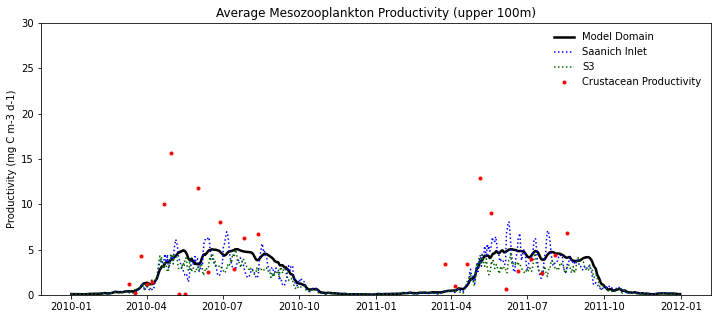

In [32]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.plot(tlist,(meanMESZtotal100*86400*0.3*5.7*12),'k-',label='Model Domain',linewidth=2.5) #multiply by 86400 to get d-1
ax.plot(tlist,(meanMESZtotal100SI*86400*0.3*5.7*12),':',color='blue',label='Saanich Inlet') #multiply by 5.7 and 12 to convert to mg C m-3
ax.plot(tlist,(meanMESZtotal100S3*86400*0.3*5.7*12),':',color='darkgreen',label='S3')
ax.plot(df['dtUTC'],df['Production (mg C m-3 d-1)'],'.',color='red',label='Crustacean Productivity')
ax.legend(frameon=False)
ax.set_ylim((0,30))
ax.set_ylabel('Productivity (mg C m-3 d-1)')
ax.set_title('Average Mesozooplankton Productivity (upper 100m)')



Import model data for comparison with observations

In [33]:

start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2011,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'GRMESZDIAT':'dia2_T','GRMESZPHY':'dia2_T','GRMESZMICZ':'dia2_T','GRMESZMRUB':'dia2_T',\
         'GRMESZPON':'dia2_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'dia2_T':24,'grid_T':24} #24 for hours averaged 

In [34]:
PATH= '/results2/SalishSea/nowcast-green.201905/'

In [35]:
df2=pd.read_excel('/ocean/ksuchy/MOAD/observe/SaanichGrowthRatesbyDepth.xlsx',engine='openpyxl')

In [36]:
data=et.matchData(df2,filemap,fdict,start_date,end_date,namfmt,PATH,flen,quiet=False,method='vertNet');

ftype=dia2_T, are you sure? (if yes, add to list)


In [37]:
data

,dtUTC,Lat,Lon,Z_lower,Z_upper,P/B,Productivity (mg C m-3 d-1),j,i,mod_GRMESZDIAT,mod_GRMESZPHY,mod_GRMESZMICZ,mod_GRMESZMRUB,mod_GRMESZPON,k_upper,k_lower
0,2010-03-11,48.59,-123.51,5,0,0.044129,1.750165,343,198,1.015344e-07,3.965160e-07,6.095678e-08,2.827948e-07,5.396732e-08,0,4
1,2010-03-11,48.59,-123.51,25,0,0.158474,5.320303,343,198,4.740443e-08,2.530406e-07,1.759674e-08,1.363575e-07,8.768528e-08,0,20
2,2010-03-11,48.59,-123.51,50,0,0.006078,0.187449,343,198,2.467757e-08,1.547190e-07,8.961642e-09,7.186004e-08,6.977479e-08,0,23
3,2010-03-11,48.59,-123.51,75,0,0.070781,1.998146,343,198,1.444392e-08,9.194011e-08,5.240036e-09,4.201788e-08,4.289083e-08,0,25
4,2010-03-18,48.59,-123.51,5,0,0.037767,0.946501,343,198,3.176289e-07,3.958652e-07,1.099075e-07,3.991029e-07,4.529318e-08,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2011-08-17,48.59,-123.51,25,0,0.080900,1.450128,343,198,6.491772e-07,2.100237e-06,1.120745e-06,4.468670e-07,9.109389e-07,0,20
129,2011-08-17,48.59,-123.51,75,0,0.076869,2.028692,343,198,2.002612e-07,6.358059e-07,3.417488e-07,1.331214e-07,6.001178e-07,0,25
130,2011-08-17,48.59,-123.51,5,0,0.377273,7.411175,343,198,8.794318e-07,7.480325e-06,3.059509e-06,1.106712e-06,9.082496e-07,0,4
131,2011-08-17,48.59,-123.51,15,0,0.083013,1.820181,343,198,9.948599e-07,3.443430e-06,1.737285e-06,6.997294e-07,9.976845e-07,0,14


In [38]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [39]:
data.keys()

Index(['dtUTC', 'Lat', 'Lon', 'Z_lower', 'Z_upper', 'P/B',
       'Productivity (mg C m-3 d-1)', 'j', 'i', 'mod_GRMESZDIAT',
       'mod_GRMESZPHY', 'mod_GRMESZMICZ', 'mod_GRMESZMRUB', 'mod_GRMESZPON',
       'k_upper', 'k_lower'],
      dtype='object')

In [40]:
data['mod_prod']=(data['mod_GRMESZDIAT']+data['mod_GRMESZPHY']+data['mod_GRMESZMICZ']+data['mod_GRMESZMRUB']+data['mod_GRMESZPON'])*86400*0.3*5.7*12

In [41]:
data

,dtUTC,Lat,Lon,Z_lower,Z_upper,P/B,Productivity (mg C m-3 d-1),j,i,mod_GRMESZDIAT,mod_GRMESZPHY,mod_GRMESZMICZ,mod_GRMESZMRUB,mod_GRMESZPON,k_upper,k_lower,mod_prod
0,2010-03-11,48.59,-123.51,5,0,0.044129,1.750165,343,198,1.015344e-07,3.965160e-07,6.095678e-08,2.827948e-07,5.396732e-08,0,4,1.588135
1,2010-03-11,48.59,-123.51,25,0,0.158474,5.320303,343,198,4.740443e-08,2.530406e-07,1.759674e-08,1.363575e-07,8.768528e-08,0,20,0.961077
2,2010-03-11,48.59,-123.51,50,0,0.006078,0.187449,343,198,2.467757e-08,1.547190e-07,8.961642e-09,7.186004e-08,6.977479e-08,0,23,0.585054
3,2010-03-11,48.59,-123.51,75,0,0.070781,1.998146,343,198,1.444392e-08,9.194011e-08,5.240036e-09,4.201788e-08,4.289083e-08,0,25,0.348438
4,2010-03-18,48.59,-123.51,5,0,0.037767,0.946501,343,198,3.176289e-07,3.958652e-07,1.099075e-07,3.991029e-07,4.529318e-08,0,4,2.247714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2011-08-17,48.59,-123.51,25,0,0.080900,1.450128,343,198,6.491772e-07,2.100237e-06,1.120745e-06,4.468670e-07,9.109389e-07,0,20,9.268806
129,2011-08-17,48.59,-123.51,75,0,0.076869,2.028692,343,198,2.002612e-07,6.358059e-07,3.417488e-07,1.331214e-07,6.001178e-07,0,25,3.388163
130,2011-08-17,48.59,-123.51,5,0,0.377273,7.411175,343,198,8.794318e-07,7.480325e-06,3.059509e-06,1.106712e-06,9.082496e-07,0,4,23.817918
131,2011-08-17,48.59,-123.51,15,0,0.083013,1.820181,343,198,9.948599e-07,3.443430e-06,1.737285e-06,6.997294e-07,9.976845e-07,0,14,13.958241


In [42]:
def byDepth(ax,obsvar,modvar,lims):
    SI=et.varvarPlot(ax,data,obsvar,modvar,'Z_lower',(15,50),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=SI)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SI,l

(0.0, 40.0)

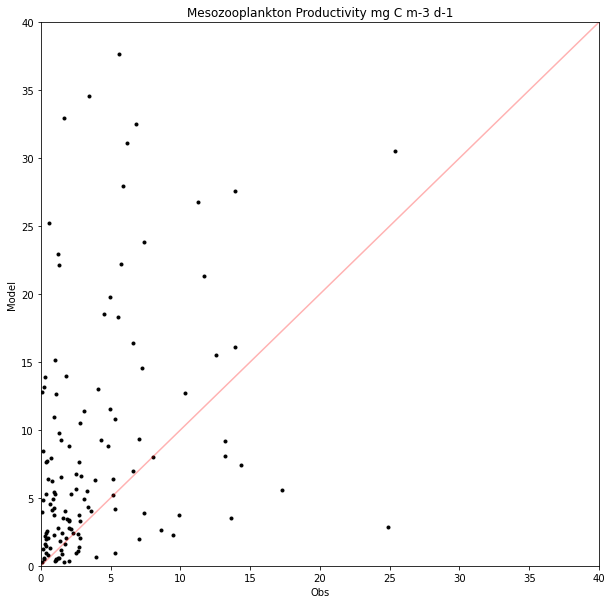

In [43]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.subplots_adjust(hspace=1)
ax.plot(data['Productivity (mg C m-3 d-1)'],data['mod_prod'],'k.')
ax.set_title('Mesozooplankton Productivity mg C m-3 d-1')
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.plot((0,40),(0,40),'r-',alpha=.3)
ax.set_xlim(0,40)
ax.set_ylim(0,40)

Text(0.5, 1.0, 'Mesozooplankton Productivity mg C m-3 d-1 By Depth')

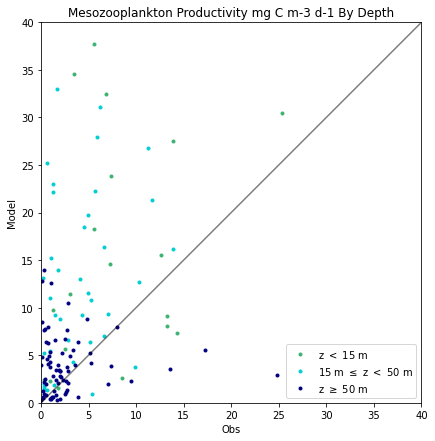

In [44]:
obsvar='Productivity (mg C m-3 d-1)'
modvar='mod_prod'

fig, ax = plt.subplots(1,1,figsize = (16,7))
SI,l=byDepth(ax,obsvar,modvar,(0,40))
ax.set_title('Mesozooplankton Productivity mg C m-3 d-1 By Depth')

In [45]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

In [46]:
data['L10Productivity']=logt(data['Productivity (mg C m-3 d-1)'])
data['L10mod_prod']=logt(data['mod_prod'])

### Depth-specific Point by Point comparisions of model vs obs

Text(0.5, 1.0, 'Mesozooplankton Productivity mg C m-3 d-1 By Depth')

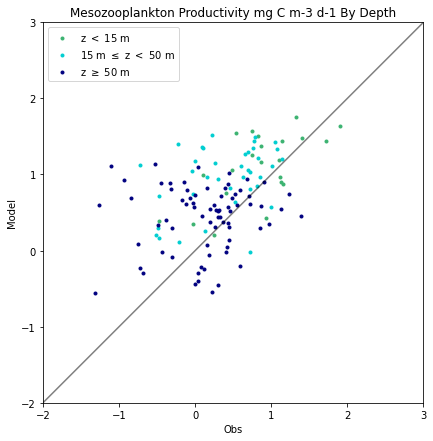

In [47]:
obsvar2='L10Productivity'
modvar2='L10mod_prod'

fig, ax = plt.subplots(1,1,figsize = (16,7))
SI,l=byDepth(ax,obsvar2,modvar2,(-2,3))
ax.set_title('Mesozooplankton Productivity mg C m-3 d-1 By Depth')